In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [2]:
mnist_transform=transforms.Compose([
                              transforms.Resize((28,28)),
                              transforms.ToTensor(), # first, convert image to PyTorch (float) tensor
                              transforms.Normalize((0.5,), (0.5,)) # normalize inputs, x' = (x-u)/std, x'=[-1, 1] 
                              ])     

train_dataset = datasets.MNIST(root='./mnist_data', 
                                  train=True, 
                                  download=True, 
                                  transform=mnist_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True) 
# shuffle training data before each epoch to avoid local min

# validation or test 
validation_dataset = datasets.MNIST(root='./mnist_data', 
                                  train=False, 
                                  download=True, 
                                  transform=mnist_transform)

validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False) 
#print(train_dataset)
#print(validation_dataset)

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# contruct model architecture

In [4]:
class CNN_MNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 15, 
                           kernel_size = 5, stride = 1, padding = 0)
    self.conv2 = nn.Conv2d(in_channels = 15, out_channels = 30, 
                           kernel_size = 3, stride = 1, padding = 0)
    self.fc1 = nn.Linear(5*5*30, 500)
    self.fc2 = nn.Linear(500, 10)

  def forward(self, x):
    x = F.tanh(self.conv1(x))
    x = F.max_pool2d(x, kernel_size = 2, stride = 2)
    x = F.tanh(self.conv2(x))
    x = F.max_pool2d(x, kernel_size = 2, stride = 2)
    x = x.view(-1, 5*5*30)      # flattening, torch.Size([batch 100, 5*5*30=750])  
    x = F.tanh(self.fc1(x))
    x = self.fc2(x)
    return x

# make model instance 


In [5]:
torch.manual_seed(1)
model = CNN_MNIST()
model

CNN_MNIST(
  (conv1): Conv2d(1, 15, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(15, 30, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=750, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

# optimizer 

In [6]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss() # cf. BCE()

In [8]:
epochs = 20
running_loss_history = []
running_corrects_history = []
validation_running_loss_history = []
validation_running_corrects_history = []

for eno in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  validation_running_loss = 0.0
  validation_running_corrects = 0.0

  # a batch of 100 images x 600 batches -> 60,000 for a single epoch 
  for inputs, labels in train_loader:     
    # input [100(batch size), 1(channel), 28(width), 28(height)] =>     
    ## inputs = inputs.view(inputs.shape[0], -1) # [100, 784]
    outputs = model(inputs) # logits (scores)
    loss = criterion(outputs, labels) # outputs [100, 1], labels [100]
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #max function output(max, max_indices)
    _, pred_idx = torch.max(outputs, 1) # 2nd argument - the dim to reduce    

    running_loss += loss.item() # loss per batch 
    running_corrects += torch.sum(pred_idx == labels.data)
  else:
    with torch.no_grad():
      for validation_inputs, validation_labels in validation_loader:     
        # input [100(batch size), 1(channel), 28(width), 28(height)] =>     
        ## validation_inputs = validation_inputs.view(validation_inputs.shape[0], -1) # [100, 784]
        validation_outputs = model(validation_inputs) # logits (scores)
        validation_loss = criterion(validation_outputs, validation_labels) # outputs [100, 1], labels [100]
        
        #max function output(max, max_indices)
        _, pred_idx = torch.max(validation_outputs, 1) # 2nd argument - the dim to reduce    

        validation_running_loss += validation_loss.item() # loss per batch 
        validation_running_corrects += torch.sum(pred_idx == validation_labels.data)

    epoch_loss = running_loss/len(train_loader) 
    running_loss_history.append(epoch_loss)
    epoch_acc = (running_corrects.float()/inputs.shape[0]*100)/len(train_loader) 
    running_corrects_history.append(epoch_acc)
    print('--------------- epoch: ', (eno+1), '---------------')
    print('training loss: {:.4f}, accuracy {:.4f}'.format(epoch_loss, epoch_acc.item()))   

    validation_epoch_loss = validation_running_loss/len(validation_loader) 
    validation_running_loss_history.append(validation_epoch_loss)
    validation_epoch_acc = (validation_running_corrects.float()/validation_inputs.shape[0]*100)/len(validation_loader) 
    validation_running_corrects_history.append(validation_epoch_acc)    
    print('validation loss: {:.4f}, accuracy {:.4f}'.format(validation_epoch_loss, validation_epoch_acc.item())) 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


--------------- epoch:  1 ---------------
training loss: 0.0951, accuracy 97.2633
validation loss: 0.0832, accuracy 97.6600
--------------- epoch:  2 ---------------
training loss: 0.0890, accuracy 97.4500
validation loss: 0.0781, accuracy 97.8000
--------------- epoch:  3 ---------------
training loss: 0.0838, accuracy 97.5500
validation loss: 0.0742, accuracy 97.8400
--------------- epoch:  4 ---------------
training loss: 0.0795, accuracy 97.7200
validation loss: 0.0705, accuracy 97.9800
--------------- epoch:  5 ---------------
training loss: 0.0757, accuracy 97.8067
validation loss: 0.0670, accuracy 97.9600
--------------- epoch:  6 ---------------
training loss: 0.0723, accuracy 97.8833
validation loss: 0.0644, accuracy 98.1100
--------------- epoch:  7 ---------------
training loss: 0.0693, accuracy 98.0150
validation loss: 0.0621, accuracy 98.1700
--------------- epoch:  8 ---------------
training loss: 0.0666, accuracy 98.0500
validation loss: 0.0601, accuracy 98.2100
--------

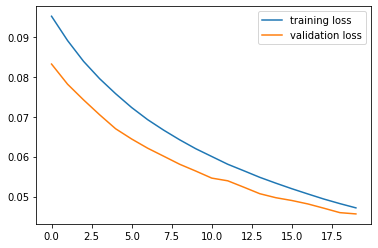

In [11]:
plt.plot(running_loss_history, label='training loss')
plt.plot(validation_running_loss_history, label='validation loss')
plt.legend()

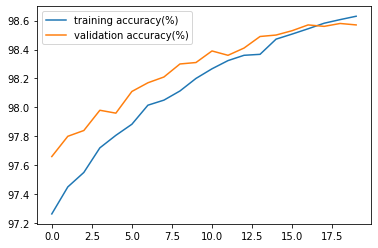

In [12]:
plt.plot(running_corrects_history, label='training accuracy(%)')
plt.plot(validation_running_corrects_history, label='validation accuracy(%)')
plt.legend()

# minist data visualization 

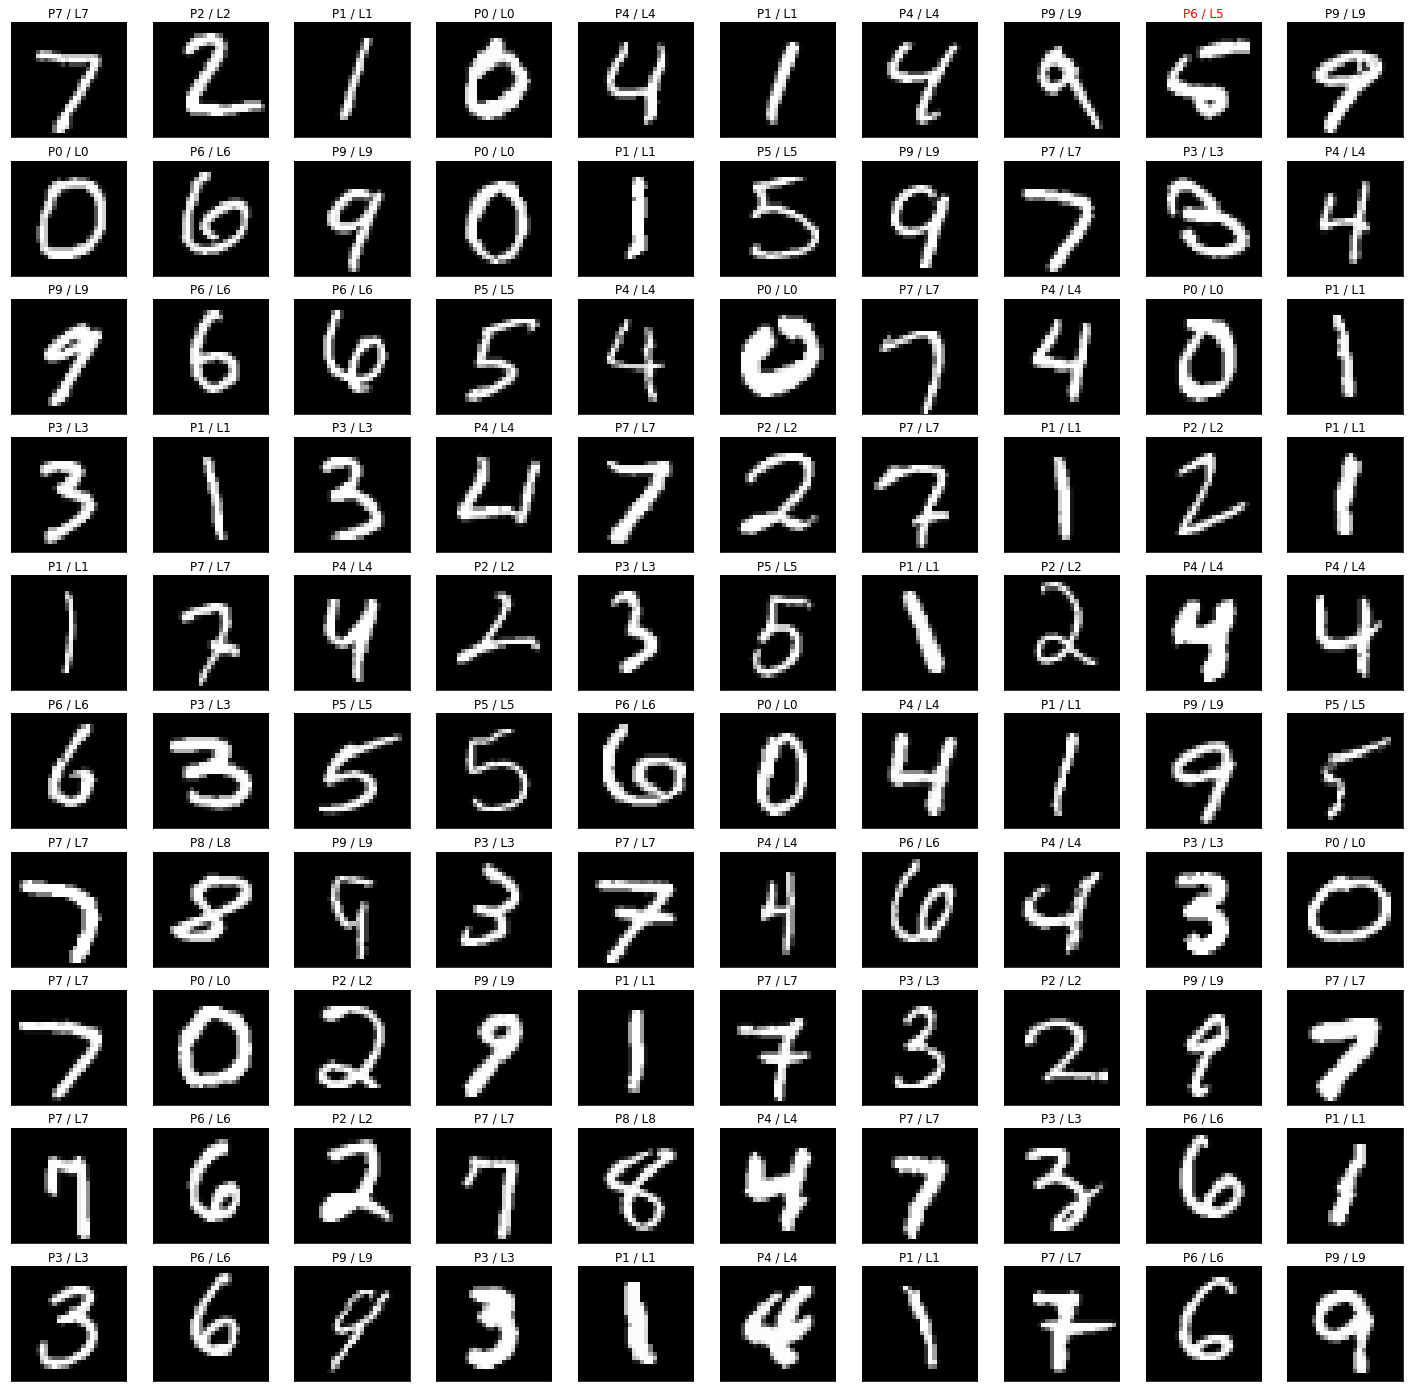

In [ ]:
# iter() returns an iterator for the given iterable object
dataiter = iter(validation_loader)
inputs, labels = dataiter.next()
#outputs = model(inputs.view(inputs.shape[0], -1)) # logits (scores)
outputs = model(inputs) # logits (scores)
_, pred_idx = torch.max(outputs, 1) # 2nd argument - the dim to reduce    

fig = plt.figure(figsize=(25, 25))

for idx in np.arange(len(dataiter)): 
  ax = fig.add_subplot(10, 10, idx+1, xticks=[], yticks=[])

  image = inputs[idx].clone().detach().numpy() # [1, 28, 28] = [channel, width, height]
  image = image.transpose(1, 2, 0) # [28, 28, 1]
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # denomalization : x' = (x-u)/std => x = x'*std + u
  image = image.clip(0, 1)
  plt.imshow(image)

  ax.set_title("P{} / L{}".format(str(pred_idx[idx].item()), str(labels[idx].item())), color=("red" if pred_idx[idx]!=labels[idx] else "black"))



  
